# **Loan Default Prediction**

## **Goal**
- Build a ML enable web appplication to predict whether a loan backed by the Small Business Administration (SBA) government agency will pay off in full or default.

## **Objectives**

- Explorate and clean the SBA Loan Dataset

- Build & Train an Ml model to classify if a loan is defaulted or not 

- Deploy the model a web application with FastApi

![Loan image](https://cdn.pixabay.com/photo/2020/02/18/08/35/finance-4858797_960_720.jpg)



Author: Luis Fernando Salazar Salinas Date: 18/05/2022

### **Loan Default Dataset**

The original data set is from the U.S.SBA loan database, which includes historical data from 1987 through 2014 (899,164 observations) with 27 variables. The data set includes information on whether the loan was paid off in full or if the SBA had to charge off any amount and how much that amount was. 

According to Li, Mickel, & Taylor 2018, the project filtered the  original dataset to California State and  add the following new variables:

- New
- Portion 
- RealEstate
- Recession
- Default(Target)


For more information on this data set, visit the follow url: https://amstat.tandfonline.com/doi/full/10.1080/10691898.2018.1434342

### **Install and Import the libraries**

In [ ]:
!pip install category-encoders

In [ ]:
!pip install imbalanced-learn

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
!pip install MarkupSafe==2.0.1

In [ ]:
!pip install hyperopt

In [ ]:
!pip install shap

In [ ]:
!pip install lightgbm --upgrade

In [ ]:
!pip install xgboost --upgrade

In [1]:
## importing the libraries
import os 
import warnings
warnings.simplefilter(action ="ignore")
#import wget
import pickle

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import numpy as np
import pandas as pd

from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb

### **Import and manipulate data**

In [ ]:
## Conect with google drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
def wrangle(input_path):
    
    ## Conver to Dataframe
    df = pd.read_csv(input_path)
    
    ## Mask to State 'California' (Spatial limit)
    mask_ca = df['State'] == 'CA'
    
    ## Apply mask
    df = df[mask_ca]
    
    ## Remove symbols 
    list_s = ['DisbursementGross','GrAppv','SBA_Appv']

    for colm in list_s:
        df[colm] = df[colm].str.replace('[$,]', '').astype(float)
    
        
    ## List of unnecessary, inconsistent and leaky variables
    list_un = ['LoanNr_ChkDgt','Name','City','State', 'Zip','Bank',
               'BankState','NAICS','ApprovalDate','NewExist',
               'ApprovalFY', 'FranchiseCode','ChgOffPrinGr','ChgOffDate',
               'BalanceGross','RevLineCr','LowDoc','CreateJob','RetainedJob','UrbanRural'
        
    ]
     
    ## Maintain the 10 cities with the most information and classify the other cities as others
    #ten_cities = df['City'].value_counts().head(10).index
    #df['City'] = df['City'].apply(lambda c : c if c in ten_cities else 'Others')
    
    ## Setting the DisbursementDate
    df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate']).astype(str)
    df['DisbursementDate'] = df['DisbursementDate'].str.split('-', expand = True)[0]
    
    ## Create Recession variable
    list_rece = []
    
    for rece in df['DisbursementDate']:
        if rece >= '2007' and rece <= '2009':
            rece = 1
        else:
            rece = 0
        list_rece.append(rece)
    
    df['Recession'] = list_rece
    
    list_un.append('DisbursementDate')
    
    
    # Create a Real State variable 
    list_real = []
    
    for real in df['Term']:
        if real >=240:
            real = 1
        else:
            real = 0
        list_real.append(real)
        
    df['RealEstate'] = list_real
    

    # SBA's Guaranteed Portion of Approved Loan
    df['portion'] = df['SBA_Appv']/ df['GrAppv']
    
    
    # New target variable
    df['Default'] = (df['MIS_Status'] == 'CHGOFF').astype(int)
    
    #Remove old target variable
    list_un.append('MIS_Status')
    
    # Drop columns
    df.drop(columns = list_un, inplace = True)
     
    return df

In [4]:
df = wrangle('/content/drive/MyDrive/Loan_Default/SBAnational.csv').reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130619 entries, 0 to 130618
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   NAICS_2DIG           101918 non-null  float64
 1   Industry_definition  101918 non-null  object 
 2   Term                 130619 non-null  int64  
 3   NoEmp                130619 non-null  int64  
 4   New                  130496 non-null  float64
 5   DisbursementGross    130619 non-null  float64
 6   GrAppv               130619 non-null  float64
 7   SBA_Appv             130619 non-null  float64
 8   Recession            130619 non-null  int64  
 9   RealEstate           130619 non-null  int64  
 10  portion              130619 non-null  float64
 11  Default              130619 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 12.0+ MB


In [5]:
print(f"Data dimensionality {df.shape}")
df.head(10)

Data dimensionality (130619, 12)


NAICS_2DIG                               Industry_definition  Term  NoEmp  \
0        61.0                              Educational Services    83     18   
1         NaN                                               NaN    84      6   
2         NaN                                               NaN    84      2   
3        31.0                                     Manufacturing    36     20   
4         NaN                                               NaN   300     50   
5        54.0  Professional, Scientific, and Technical Services    84      2   
6        81.0                                    Other Services    84      3   
7         NaN                                               NaN    60      3   
8        42.0                                   Wholesale Trade    36     18   
9        51.0                                       Information    84      1   

   New  DisbursementGross    GrAppv  SBA_Appv  Recession  RealEstate  portion  \
0  1.0           438541.0  100000.0   50000.0          0           0     0.50   
1  0.0            30570.0   25000.0   12500.0          0           0     0.50   
2  0.0            15000.0   15000.0    7500.0          0           0     0.50   
3  1.0            35000.0   35000.0   17500.0          0           0     0.50   
4  0.0           745000.0  745000.0  558750.0          0           1     0.75   
5  0.0            18107.0   20000.0   10000.0          0           0     0.50   
6  0.0            10000.0   10000.0    5000.0          0           0     0.50   
7  0.0            40000.0   40000.0   32000.0          0           0     0.80   
8  0.0           577000.0  300000.0  150000.0          0           0     0.50   
9  1.0             5000.0    5000.0    4250.0          0           0     0.85   

   Default  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0

### **Exploratory Data Analysis**

- Report:
   - Missing values 
   - Outliers
   - Duplicates observation
   - Distributions 
   - Correlactions
   - Interactions

- Visial analysis
  - Loan Status during Recessesion
  - Loan Status Backed by Real Estate
  - Loan Status by Gross Disbursement
  - Loan Status by the SBA’s Guaranteed Amount of Approved
  - Frequency of loan default/pif by industry

#### **Pandas profile report** 

In [6]:
## Pandas profile Report
report = ProfileReport(df,
                       title = 'National SBA data',
                       dataset ={
                           'description': "This profile report was generated by Luis F. Salazar Salinas",
                           'copyright_holder': "Luis Salazar",
                           'copyright_year': "2022",
                           'url':"https://github.com/Luissalazarsalinas"
                       },
                       variables = {
                           'descriptions':{
                               'City': 'Barrower City(only to California State)',
                               'NAICS_2DIG': 'North American Industry Classification System code',
                               'Industry_definition':' Industry Definition from North American Industry Classification System code',
                               'Term':'Loan term in months',
                               'NoEmp': 'Number of Business Employees',
                               'New':'0 = Existing Business, 1 = New Business',
                               'DisbursementGross': 'Amount Disbursed',
                               'GrAppv':'Gross Amount of Loan Approved by Bank',
                               'SBA_Appv': 'SBA’s Guaranteed Amount of Approved Loan',
                               'Recession': '1= if loan is active during Great Recession, 0= otherwise',
                               'RealEState': '1= if loan is backed by real estate, 0= otherwise',
                               'portion	': 'Proportion of Gross Amount Guaranteed by SBA',
                               'Default': '1= if MIS_Status=CHGOFF, 0= if MIS_Status=P I F',

                           }
                       },
                       html = {'style':{'full_width':False}})

In [7]:
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Save report 
report.to_file('Loan_default_report.html')
report.to_file('Loan_default_report.json')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### **Visual analysis**

##### **Recession**

In [ ]:
### Ressecion analysis 
default_reces = pd.DataFrame(df.groupby('Recession')['Default'].mean())
## Proportions of loan paid in full during recession
default_reces['Loan Paid in Full'] = (
    df[(df['Default'] == 0.0) ].groupby('Recession')['Default'].count()/
    df.groupby('Recession')['Default'].count()
)
## Proportions of loan default during recession
default_reces['Loan Default'] = (
    df[(df['Default'] == 1.0) ].groupby('Recession')['Default'].count()/
    df.groupby('Recession')['Default'].count()
)
default_reces.drop(columns = 'Default', inplace = True)

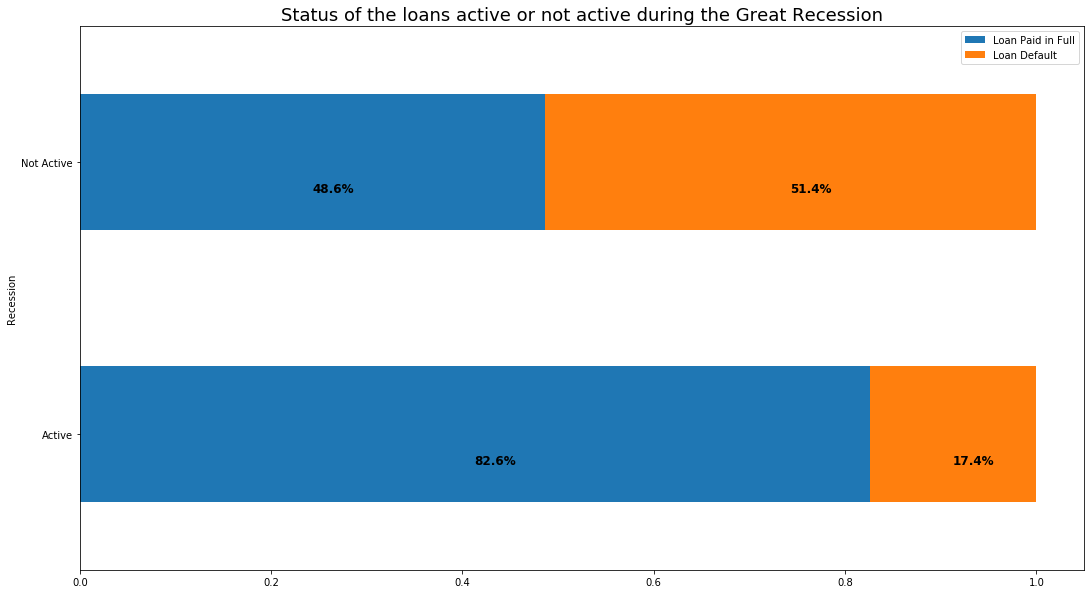

In [ ]:
fig, ax = plt.subplots(figsize = (18,10))
default_reces.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Status of the loans active or not active during the Great Recession', fontsize = 18)
plt.legend(loc = 'upper right')

for n, x in enumerate([*default_reces.index.values]):
    for (proportion, y_loc) in zip(default_reces.loc[x],
                                   default_reces.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
        
ax.yaxis.set_ticklabels(['Active','Not Active'])

plt.show()

 ###### **Observations**

 - By the analysis of the state of credits during the recession period, we can see that 50.6% of the credits were not paid in full and 49.4% were paid in full This reflects the impact that the economic recession period had on the economy of the US industries because when we analyze the credits that were not activated in the period of economic recession, we can see that 86.5% of the credits were paid in full and only 13.5% of the credits were not paid completely.



##### **Real Estate**

In [ ]:
### Ressecion analysis 
default_rst = pd.DataFrame(df.groupby('RealEstate')['Default'].mean())
## Proportions of loan paid in full during recession
default_rst['Loan Paid in Full'] = (
    df[(df['Default'] == 0.0) ].groupby('RealEstate')['Default'].count()/
    df.groupby('RealEstate')['Default'].count()
)
## Proportions of loan default during recession
default_rst['Loan Default'] = (
    df[(df['Default'] == 1.0) ].groupby('RealEstate')['Default'].count()/
    df.groupby('RealEstate')['Default'].count()
)
default_rst.drop(columns = 'Default', inplace = True)

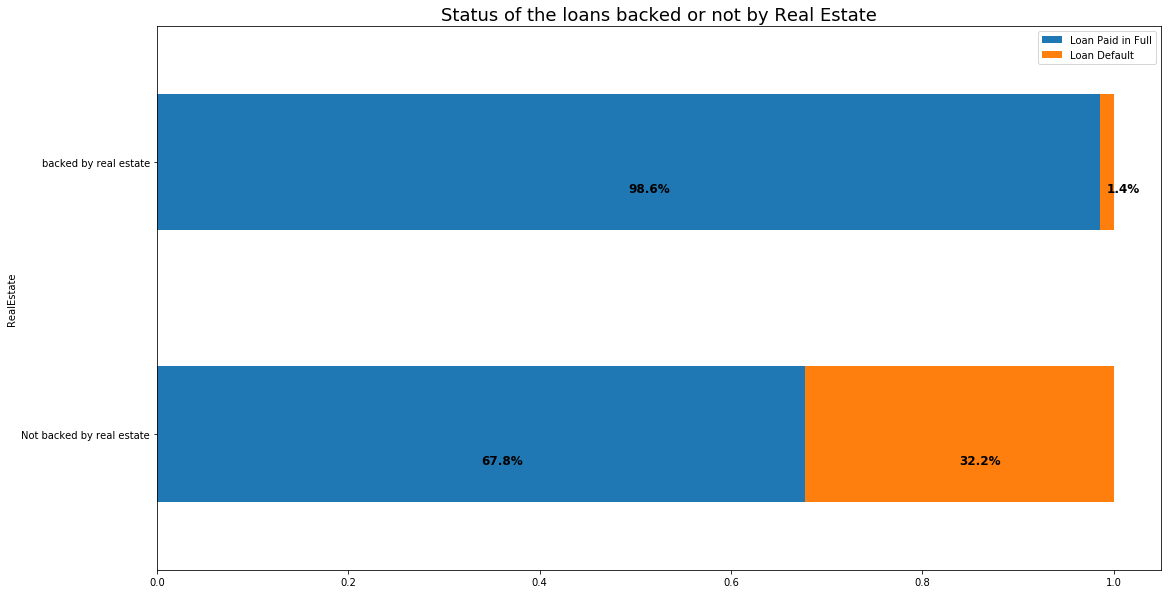

In [ ]:
fig, ax = plt.subplots(figsize = (18,10))
default_rst.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Status of the loans backed or not by Real Estate', fontsize = 18)
plt.legend(loc = 'upper right')

for n, x in enumerate([*default_rst.index.values]):
    for (pro, y_loc) in zip(default_rst.loc[x],
                            default_rst.loc[x].cumsum()):
                
        plt.text(x=(y_loc - pro) + (pro / 2),
                 y=n - 0.11,
                 s=f'{np.round(pro * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
        

ax.yaxis.set_ticklabels(['Not backed by real estate','backed by real estate'])

plt.show()

###### **Observations**
- 98.8% of the loans backed for real estate were paid in full, while 1.2% were not paid in full. In this sense, the pattern shown in the chart reflects the importance that has this type of financial security.

##### **Loan Status**

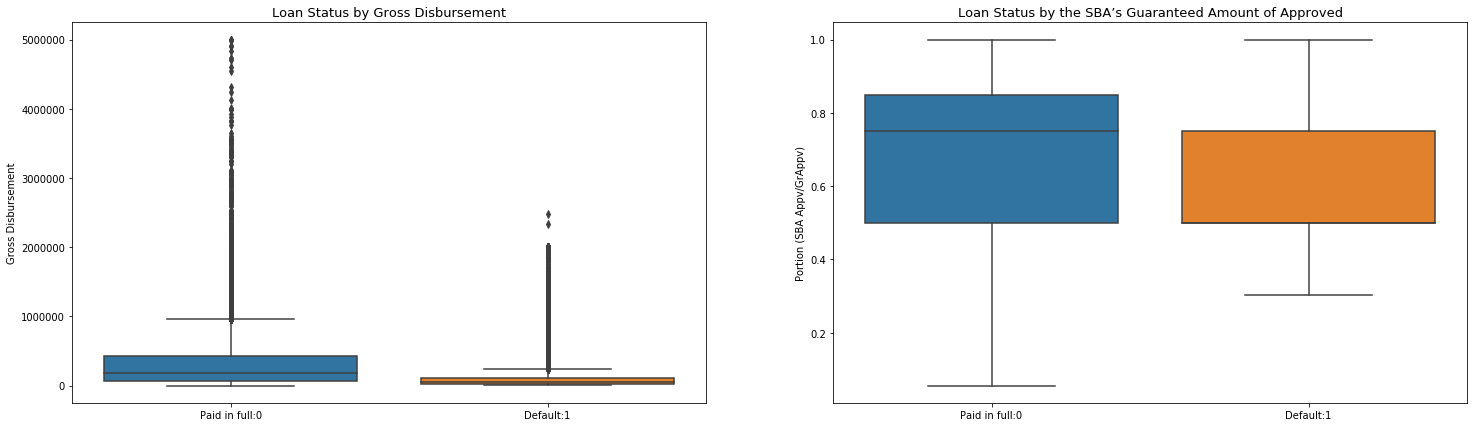

In [ ]:
fig = plt.figure(figsize =(25,7))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Gross Disbursement vs Default plot
sns.boxplot(x=df['Default'], y=df['DisbursementGross'], ax = ax0)
ax0.set_xlabel('')
ax0.set_ylabel('Gross Disbursement')
ax0.set_title('Loan Status by Gross Disbursement', fontsize = 13)
ax0.xaxis.set_ticklabels(["Paid in full:0", "Default:1"])

# Portion vs Default plot
sns.boxplot(x=df['Default'], y=df['portion'] , ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Portion (SBA Appv/GrAppv)')
ax1.xaxis.set_ticklabels(["Paid in full:0", "Default:1"])
ax1.set_title('Loan Status by the SBA’s Guaranteed Amount of Approved',fontsize = 13);

 ###### **Observations**
 - The box plot of Loan Status by Gross Disbursement shows us that i) there are presence of outliers and ii) the median of the loans paid in full is greater than of the loans defaulted, to a greater amount of Gross Disbursement by banks.

- The box plot of Loan Status by the SBA’s Guaranteed Amount of Approved shows us that a higher percentage of money covered by the SBA could help reduce the rate of credit defaults by companies.

##### **Industries**

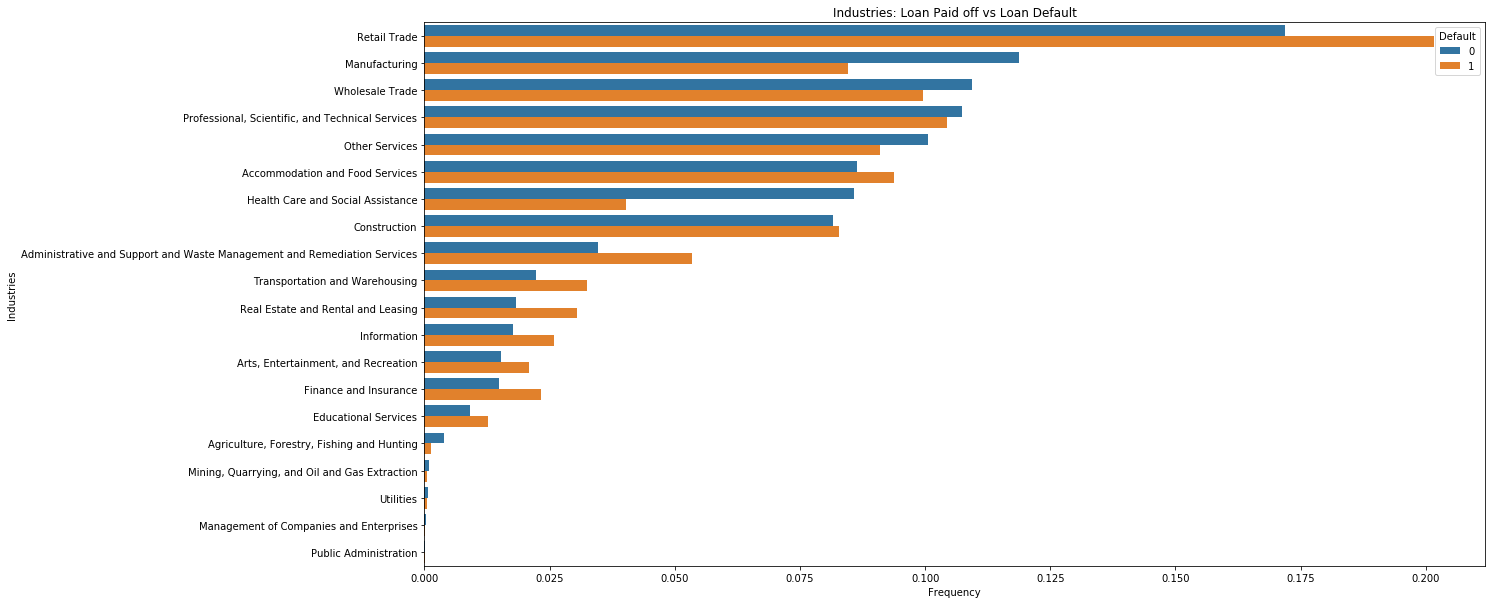

In [ ]:
##
indu_status =(
    df['Industry_definition']
    .groupby(df['Default'])
    .value_counts(normalize = True)
    .rename('Frequency')
    .to_frame()
    .reset_index()
)
#Plot
fig, ax = plt.subplots(figsize = (19,10))

sns.barplot(data = indu_status,
            x = 'Frequency',
            y = 'Industry_definition',
            hue = 'Default',
            ax = ax
            )

ax.set(xlabel = 'Frequency',
       ylabel = 'Industries',
       title =  'Industries: Loan Paid off vs Loan Default'
);

### **Data Cleaning** 

In [9]:
def clean(df):
    
    # Drop Unnecessary variable to modeling 
    df.drop(columns = 'Industry_definition', inplace = True)
    
    # Drop missing values
    df.dropna(inplace =True)
    
    # Drop duplicate values
    df.drop_duplicates(inplace=True)
    
    # Reset index
    df.reset_index(drop = True, inplace = True)
    
    # int
    for colm in list(['NAICS_2DIG','New']):
        
        df[colm] = df[colm].astype(int)
    
    return df

In [10]:
df = clean(df)
print(df.shape)
df.head(10)

(93469, 11)


NAICS_2DIG  Term  NoEmp  New  DisbursementGross    GrAppv  SBA_Appv  \
0          61    83     18    1           438541.0  100000.0   50000.0   
1          31    36     20    1            35000.0   35000.0   17500.0   
2          54    84      2    0            18107.0   20000.0   10000.0   
3          81    84      3    0            10000.0   10000.0    5000.0   
4          42    36     18    0           577000.0  300000.0  150000.0   
5          51    84      1    1             5000.0    5000.0    4250.0   
6          44    84      9    0             7085.0   25000.0   12500.0   
7          72    84     60    0           122977.0   50000.0   25000.0   
8          81    84      1    1            95000.0   95000.0   76000.0   
9          44   120     10    0            50000.0   50000.0   37500.0   

   Recession  RealEstate  portion  Default  
0          0           0     0.50        0  
1          0           0     0.50        0  
2          0           0     0.50        0  
3          0           0     0.50        0  
4          0           0     0.50        0  
5          0           0     0.85        0  
6          0           0     0.50        0  
7          0           0     0.50        0  
8          0           0     0.80        0  
9          0           0     0.75        0

In [11]:
## Save clean dataset
df.to_csv('SBAnational_clean.csv', index= False)

### **Data Preprocessing**


In [13]:
# Split data into Features and target 
target = 'Default'
X = df.drop(columns = target)
y = df[target]


print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (93469, 10)
Labels shape: (93469,)


In [14]:
## split data using StratifiedShuffleSplit to unbalance data

strat_shuf_split = StratifiedShuffleSplit(n_splits = 1,
                                          test_size = 0.2,
                                          random_state= 42)

train_idx, test_idx = next(strat_shuf_split.split(X, y))

## Create the dataframe
X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test  = X.loc[test_idx]
y_test  = y.loc[test_idx]

In [15]:
strat_shuf_split_2 = StratifiedShuffleSplit(n_splits = 1,
                                          test_size = 0.25,
                                          random_state= 42)
                                          
train_idx, val_idx = next(strat_shuf_split_2.split(X_train, y_train))

## Create the dataframe
X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_val  = X.loc[val_idx]
y_val  = y.loc[val_idx]

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_validation shape: {X_val.shape}")
print(f"y_validation shape: {y_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (56081, 10)
y_train shape: (56081,)
X_validation shape: (18694, 10)
y_validation shape: (18694,)
X_test shape:(18694, 10)
y_test shape: (18694,)


In [17]:
# OverSampling  method to unbalance data
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
bsmote_over = BorderlineSMOTE(random_state = 42)
X_train_over, y_train_over = bsmote_over.fit_resample(X_train, y_train)
#
print(f"X train over shape: {X_train_over.shape}")
print(f"y train over shape: {y_train_over.shape}")

X train over shape: (83358, 10)
y train over shape: (83358,)


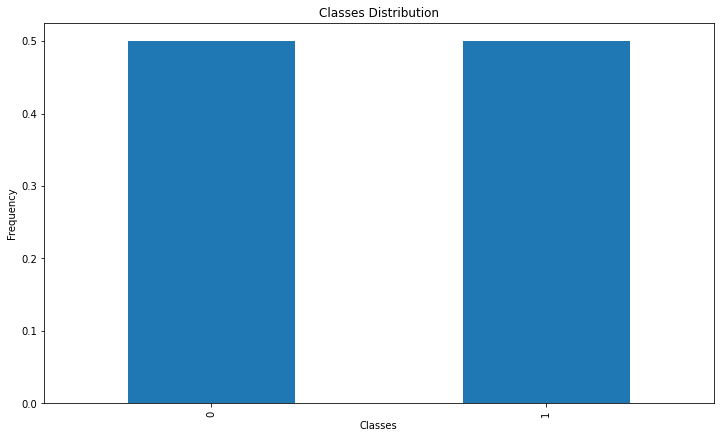

In [18]:
# Class proportions 
plt.figure(figsize = (12,7))
y_train_over.value_counts(normalize =True).plot.bar()
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Classes Distribution');

### **Modelling**
- Base line:
 - LogisticRegression
-  Models:
   - RandomForestClassifier
   - ExtraTreeClassfier
   - XGBClassifier

- Models Performances:
   - Classification Report:
      - Accuracy
      - Presicion
      - Recall
      - F1-Score
      - AUC

- Hyperparameters Tuning (the best model):
  - Bayes Optimizer (Hyperotp)

- Final Model:
  - Predictions(inference) with the test set

  - Metrics:
     - Confusion Matrix
     - Roc-Auc curve

  


In [19]:
# Model Performance
from sklearn.metrics import log_loss
dict_df = {
    'Model':['Baseline', 'RandomForest', 'ExtraTrees', 'XGBoost'],
    'Log Loss':[0,0,0,0],
    'Accuracy':[0,0,0,0],
    'Precision':[0,0,0,0],
    'Recall':[0,0,0,0],
    'F1-Score':[0,0,0,0],
    'AUC':[0,0,0,0]
}
df_result = pd.DataFrame(dict_df, columns = ['Model','Log Loss','Accuracy', 'Precision', 'Recall','F1-Score','AUC'])

def model_results(model, y_val, y_pred):
  
  inx_models = df_result[df_result['Model'] == model].index

  df_result.loc[inx_models, 'Log Loss'] = log_loss(y_val, y_pred)
  df_result.loc[inx_models, 'Accuracy'] = accuracy_score(y_val, y_pred)
  df_result.loc[inx_models, 'Precision'] = precision_score(y_val, y_pred)
  df_result.loc[inx_models, 'Recall'] = recall_score(y_val, y_pred)
  df_result.loc[inx_models, 'F1-Score'] = f1_score(y_val, y_pred)
  df_result.loc[inx_models, 'AUC'] = roc_auc_score(y_val, y_pred)

  return (df_result)

#### **Baseline**

In [20]:
## LogisticRegression model
lr_model = LogisticRegression()
##Fit the model
lr_model.fit(X_train_over,y_train_over)

LogisticRegression()

In [21]:
bs_pred = lr_model.predict(X_val)

model_results('Baseline', y_val, bs_pred)

Model  Log Loss  Accuracy  Precision    Recall  F1-Score       AUC
0      Baseline  8.853796  0.743661   0.501307  0.797382  0.615594  0.761211
1  RandomForest  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000
2    ExtraTrees  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000
3       XGBoost  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000

#### **RandomForest Model**

In [22]:
## RandomForest 
model_rf = RandomForestClassifier(
    n_estimators = 1000,
    max_depth = 10,
    criterion = 'entropy',
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
)

model_rf.fit(X_train_over, y_train_over)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [23]:
## model performance 
acc_train_rf = model_rf.score(X_train_over, y_train_over)
acc_val_rf = model_rf.score(X_val, y_val)

print(f"RandomForest Train Accuracy:{round(acc_train_rf,2)} \nRandomForest Validation Accuracy: {round(acc_val_rf,2)}")

RandomForest Train Accuracy:0.94 
RandomForest Validation Accuracy: 0.91


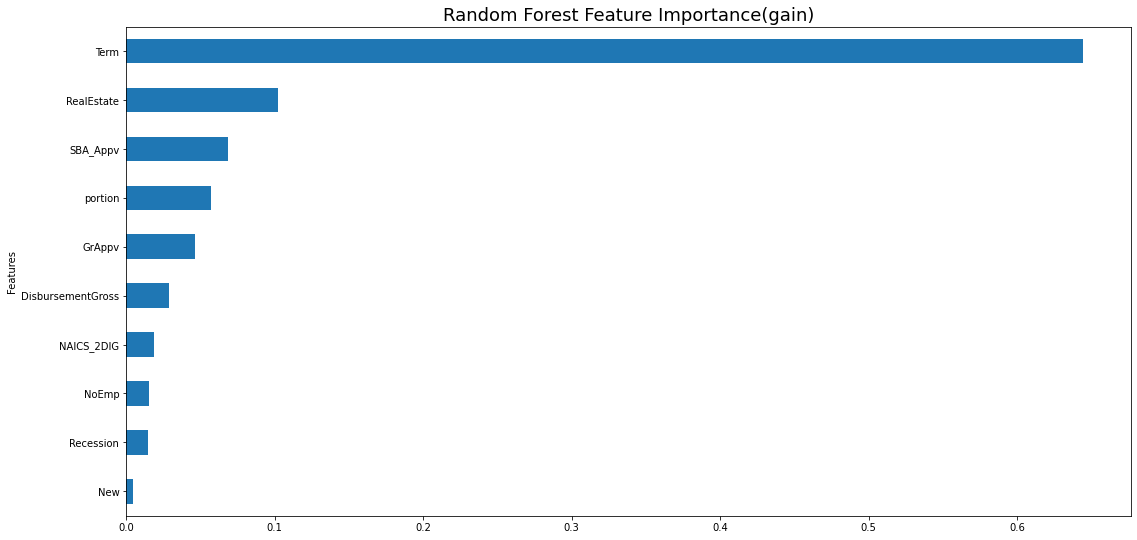

In [24]:
## RandomForest Feature importance
fea_imp_rf = pd.Series(model_rf.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_rf.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance(gain)', fontsize = 18);

In [25]:
## RandomForest Classification report with the validation set
y_pred_rf = model_rf.predict(X_val)

model_results('RandomForest', y_val, y_pred_rf)

Model  Log Loss  Accuracy  Precision    Recall  F1-Score       AUC
0      Baseline  8.853796  0.743661   0.501307  0.797382  0.615594  0.761211
1  RandomForest  3.055969  0.911522   0.762467  0.953242  0.847248  0.925151
2    ExtraTrees  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000
3       XGBoost  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000

#### **ExtraTrees Model**

In [26]:
extree_model = ExtraTreesClassifier(
    n_estimators = 1000,
    max_depth = 10,
    criterion = 'entropy',
    class_weight = 'balanced',
    random_state = 100,
    n_jobs = -1
)
extree_model.fit(X_train_over, y_train_over)

ExtraTreesClassifier(class_weight='balanced', criterion='entropy', max_depth=10,
                     n_estimators=1000, n_jobs=-1, random_state=100)

In [27]:
## model performance 
acc_train_et = extree_model.score(X_train_over, y_train_over)
acc_val_et = extree_model.score(X_val, y_val)

print(f"ExtraTrees  Train Accuracy:{round(acc_train_et,2)} \nExtraTrees Validation Accuracy: {round(acc_val_et,2)}")

ExtraTrees  Train Accuracy:0.86 
ExtraTrees Validation Accuracy: 0.84


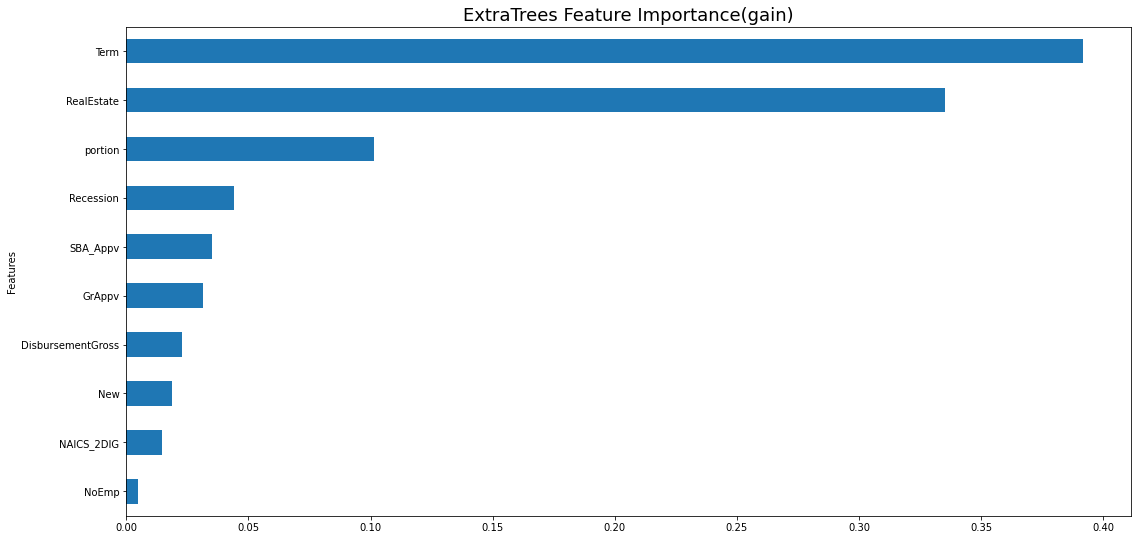

In [28]:
## RandomForest Feature importance
fea_imp_et = pd.Series(extree_model.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_et.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('ExtraTrees Feature Importance(gain)', fontsize = 18);

In [29]:
## Extratree model performnace
y_pred_et = extree_model.predict(X_val)

model_results('ExtraTrees', y_val, y_pred_et)

Model  Log Loss  Accuracy  Precision    Recall  F1-Score       AUC
0      Baseline  8.853796  0.743661   0.501307  0.797382  0.615594  0.761211
1  RandomForest  3.055969  0.911522   0.762467  0.953242  0.847248  0.925151
2    ExtraTrees  5.518850  0.840216   0.631125  0.912718  0.746241  0.863901
3       XGBoost  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000

#### **XGB Model**

In [30]:
## Scale pos weight definition
scale_pos_weight = len(df[df['Default'] == 0]) / len(df[df['Default'] == 1])

In [31]:
## XGBClassifier
model_xgb = xgb.XGBClassifier(silent = False,
                          objective = 'binary:logistic',
                          tree_method = 'gpu_hist',
                          scale_pos_weight = scale_pos_weight,
                          subsample = 0.8,
                          colsample_bytree = 0.8,
                          max_depth = 10,
                          learning_rate = 0.01,
                          n_estimators = 1000,
                          seed = 100
                          )

model_xgb.fit(X_train_over, y_train_over)

[20:03:27] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, ...)

In [32]:
## Model performance with the train a validation set
acc_train_xgb = model_xgb.score(X_train_over, y_train_over)
acc_val_xgb = model_xgb.score(X_val, y_val)

print(f"XGB Train Accuracy:{round(acc_train_xgb,2)} \nXGB Validation Accuracy: {round(acc_val_xgb,2)}")

XGB Train Accuracy:0.97 
XGB Validation Accuracy: 0.93


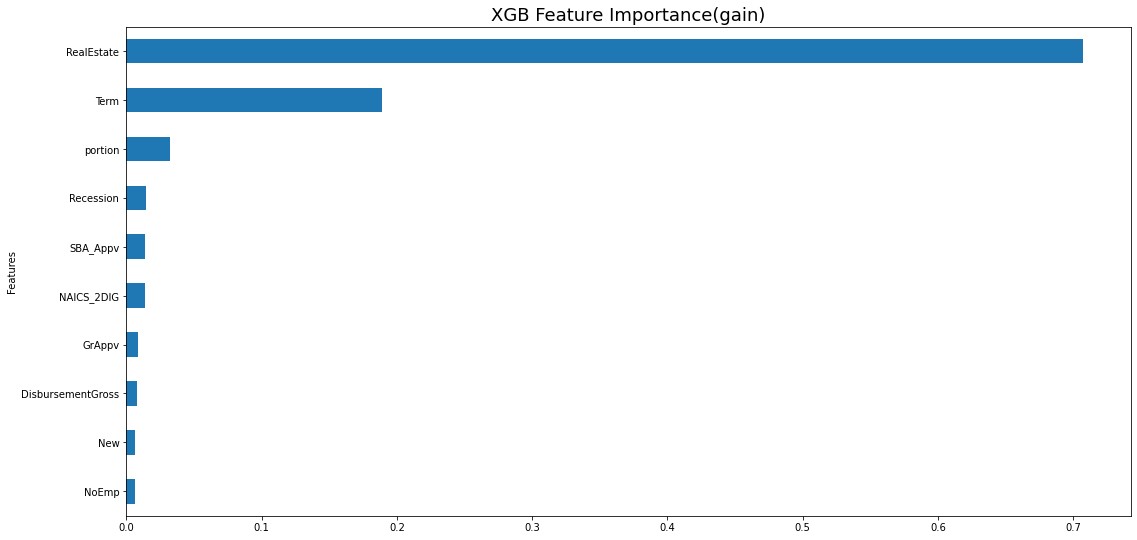

In [33]:
## Feature importance
fea_imp_xgb = pd.Series(model_xgb.feature_importances_, index = X_train.columns)

# plot of the 10 best predictors 
fea_imp_xgb.tail(10).sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Feature Importance(gain)', fontsize = 18);

In [34]:
## Xgb Classification report with the validation set
y_pred_xgb = model_xgb.predict(X_val)

model_results('XGBoost', y_val, y_pred_xgb)

Model  Log Loss  Accuracy  Precision    Recall  F1-Score       AUC
0      Baseline  8.853796  0.743661   0.501307  0.797382  0.615594  0.761211
1  RandomForest  3.055969  0.911522   0.762467  0.953242  0.847248  0.925151
2    ExtraTrees  5.518850  0.840216   0.631125  0.912718  0.746241  0.863901
3       XGBoost  2.501681  0.927570   0.800278  0.957606  0.871902  0.937382

#### **Hyperparameters Tuning (XGB Model)**

In [35]:
## Hyperparameters tuning with Bayes-optimizer 
###choose hyperparameters
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {
         'tree_method': hp.choice('tree_method',['gpu_hist']),
         'subsample': hp.uniform('subsample', 0.5, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
         'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'max_depth': hp.quniform('max_depth', 6, 12, 1),
         'gamma': hp.quniform('gamma', 1, 10, 1),
         'reg_alpha': hp.uniform('reg_alpha', 0.4, 1.0),
         'n_estimators': hp.quniform('n_estimators', 300, 3000, 1), 
         'seed' : 100 
    }

def objective(space):

  model = xgb.XGBClassifier(
                        tree_method = space['tree_method'],
                        subsample = space['subsample'],
                        colsample_bytree = space['colsample_bytree'],
                        learning_rate = space['learning_rate'],
                        min_child_weight = int(space['min_child_weight']),
                        max_depth = int(space['max_depth']),
                        gamma = int(space['gamma']),
                        reg_alpha = space['reg_alpha'],
                        n_estimators = int(space['n_estimators']),
                        seed = int(space['seed']),
                                 )
  accuracy = cross_val_score(model, X_train_over, y_train_over, cv = 4).mean()
 
  return {'loss': -accuracy, 'status': STATUS_OK }

    
trials = Trials()

best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 70,
            trials= trials)
best

100%|██████████| 70/70 [07:36<00:00,  6.52s/it, best loss: -0.9531060645554313]


{'colsample_bytree': 0.5444107816568233,
 'gamma': 1.0,
 'learning_rate': 0.18277521058550605,
 'max_depth': 7.0,
 'min_child_weight': 2.0,
 'n_estimators': 1608.0,
 'reg_alpha': 0.6669903210336711,
 'subsample': 0.7444894622279781,
 'tree_method': 0}

#### **Final Model**

In [36]:
final_model = xgb.XGBClassifier(
    
    objective = 'binary:logistic',
    tree_method = 'gpu_hist',
    learning_rate = best['learning_rate'],
    max_depth = int(best['max_depth']),
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    min_child_weight = int(best['min_child_weight']),
    reg_alpha = best['reg_alpha'],
    gamma = int(best['gamma']),
    n_estimators = int(best['n_estimators']),
    seed = 100

)

final_model.fit(X_train_over, y_train_over)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5444107816568233, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=1, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.18277521058550605,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
              max_leaves=0, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=1608, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0.6669903210336711, reg_lambda=1, ...)

##### **Evaluate the Final Model with the test set**

##### Predictions

In [37]:
y_pred = final_model.predict(X_test)
y_pred_pro = final_model.predict_proba(X_test)

##### Model Performance
- Metrics:
 - Acuraccy
 - Roc-Auc curve
 - Confusion Matrix

Accuracy: 0.9543703862201776 
Roc_Auc score: 0.9469547385214574


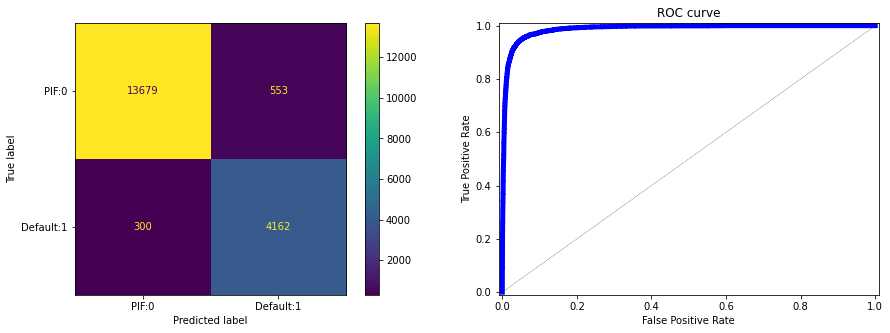

In [38]:
## Accuracy and roc_auc score
print(f"Accuracy: {accuracy_score(y_test, y_pred)} \nRoc_Auc score: {roc_auc_score(y_test, y_pred)}")

## Roc curve
fpr, tpr, thr = roc_curve(y_test, y_pred_pro[:,1])

## plot
plt.figure(figsize =(15,5))
layout = (1,2)

cmd = plt.subplot2grid(layout,(0,0))
rc = plt.subplot2grid(layout,(0,1))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = cmd)
cmd.xaxis.set_ticklabels(["PIF:0", "Default:1"])
cmd.yaxis.set_ticklabels(["PIF:0", "Default:1"])

rc.plot(fpr, tpr, color ='blue', linewidth = 5)
rc.plot([0, 1],[0, 1], ls = '--', color = 'black', lw = .3)
rc.set(xlabel = 'False Positive Rate',
       ylabel = 'True Positive Rate',
       xlim =[-.01, 1.01], ylim =[-.01, 1.01],
       title = 'ROC curve')

plt.show()

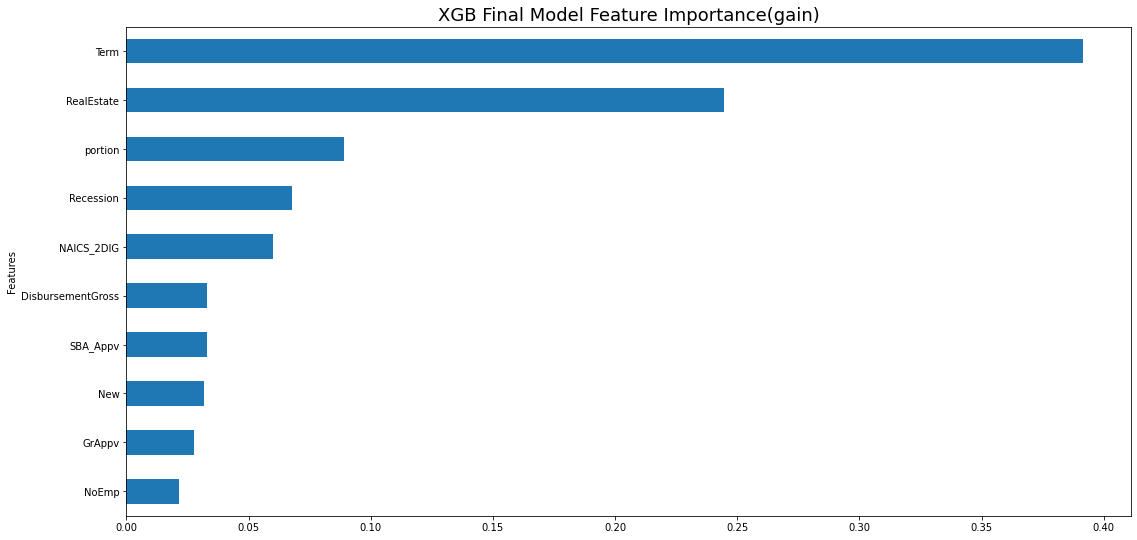

In [39]:
## Feature importance
fea_imp_xgb_h = pd.Series(final_model.feature_importances_, index = X_train_over.columns)

# plot of the 10 best predictors 
fea_imp_xgb_h.sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Final Model Feature Importance(gain)', fontsize = 18);

##### **Serialization**

In [40]:
with open('LD_Model.pkl', 'wb') as f:
  pickle.dump(final_model, f)